# Assignment 6: Point Cloud Classification & Segmentation with PointNet (20 pts)



### Conda Setup

Generate the conda environment by running in the terminal:

`conda create --name gcv_exercise_6 python=3.11`

Run to activate environment:

`conda activate gcv_exercise_6`

Install all required packages for this exercise by running:

`conda install matplotlib numpy  tqdm pandas h5py`

Install PyTorch and its prerequisites:

`conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`

(Optional) If you are working on the TUWEL Juypter Notebooks:

`ipython kernel install --name "GCV_E_6" --user`

### Notebook Setup & Imports

In [21]:
import numpy as np
import random
import h5py
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt # useful plotting library for python
import torch # framework for deep learning
import torch.nn as nn
from typing import List, Callable, Any
import torch.nn.functional as F


## 6.1 Point Cloud Classification (8pts)
In this exercise you will implement a simple version of the PointNet architecture for point cloud processing and train it to classify point cloud from the **ModelNet10** dataset (https://modelnet.cs.princeton.edu/).


### Data preparation

The first thing we will need to do is downloading the data. 

**ModelNet** is a dataset of different CAD objects. Two of the most common benchmarks used to evaluate the performance of a network to classify point clouds is **ModelNet10** and ModelNet40. **ModelNet40** is composed of almost 10k objects from 40 different classes and ModelNet10 is composed of almost 4k objects from 10 different classes. 

We have prepared a sampled version of ModelNet10 in which each object is sampled with 512 points. Please download modelnet10.zip from [here](https://tucloud.tuwien.ac.at/index.php/s/4Rxx2L7LCqQZ65S).

Here we load the hdf5 binary file and extract the different datasets:

In [22]:
dataset = h5py.File("data/modelnet10/modelnet10.hdf5") # adjust to where you saved the dataset
x_train = dataset['train_data'][:]
y_train = dataset['train_categories'][:]
x_test = dataset['test_data'][:, :, :]
y_test = dataset['test_categories'][:]

print("Point cloud training:", x_train.shape[0])
print("Point cloud testing:", x_test.shape[0])


Point cloud training: 3991
Point cloud testing: 908


We can visualize the data with a simple 2D projection:

In [23]:
def visualize_points(pos, index=None):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection='3d')

    if index is None:
        ax.scatter(pos[:, 0], pos[:, 2],pos[:,1], s=10)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       ax.scatter(pos[~mask, ], pos[~mask, 1], pos[~mask, 2],  s=50, color='lightgray', zorder=1000)
       ax.scatter(pos[mask, 0], pos[mask, 1], pos[mask, 2], s=50, zorder=1000)

    plt.show()

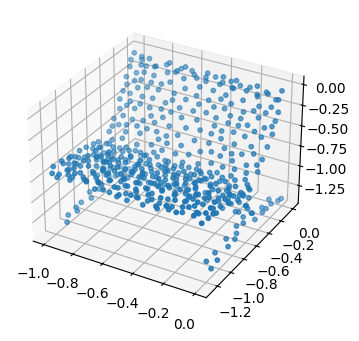

In [24]:
visualize_points(x_train[1000])

### Data augmentation (1 Pt each = 2 Pts)

In order to increase our training data and improve generalization, we are going to augment our training set by scaling it and by applying noise to each point coordinate. This will prevent the network to memorize each model in the training set. You need to implement the following 2 data augmentation strategies:
1. scaling: Compute a random scaling for each point in each axis between 0.9 and 1.1 
2. gaussian noise: Apply gaussian noise to each point coordinate with a stdev of 0.02.

In [32]:
def scale(point_cloud):
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    scale_factor = np.random.uniform(0.9, 1.1)
    scaled_point_cloud = point_cloud * scale_factor
    return scaled_point_cloud
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

def gaussian_noise(point_cloud):
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    noise = np.random.normal(0, 0.02, point_cloud.shape)
    noisy_point_cloud = point_cloud + noise
    return noisy_point_cloud
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

class TransformStack:
    def __init__(self, stack: List[Callable], transform_probability: float = 0.5) -> None:
        self.stack  = stack
        self.trf_prob = transform_probability
    def __call__(self, point_cloud) -> Any:
        for transform in self.stack:
            if random.random() < self.trf_prob:
                point_cloud = transform(point_cloud)
        return point_cloud


### Define dataset class (2 Pts)
Similar to exercise 5 we will create our Dataset and Dataloader instances for train and validation data. Here you need to implement the __getitem__ function.

In [33]:

class ModelNet10Dataset(torch.utils.data.Dataset):
    """ModelNet10 dataset.
    Args:
        x_data (numpy.ndarray): numpy ndarray from modelnet10 dataset.
        y_data (numpy.ndarray): numpy ndarray from modelnet10 dataset.
        tfm (TransformStack): composed transforms.

    Methods:
        __len__: returns the length of the dataset.
        __getitem__: returns a tuple of (pointcloud, label) as torch tensors.
    """
    def __init__(self, x_data, y_data, tfm=None):
        """Initialize the dataset.

        Args:
            x_data (numpy.ndarray): Point Clouds from thet modified Modelnet10 dataset.
            y_data (numpy.ndarray): Labels from thet modified Modelnet10 dataset.
            tfm (TransformStack): composed transforms.
        """
        self.data = x_data
        self.labels = y_data
        self.tfm = tfm

    def __len__(self):
        """Return the length of the dataset."""
        return self.data.shape[0]
    def __getitem__(self, i):
        """Return a tuple of (pointcloud, label) as torch tensors and applies transformations if not None.
        
        Args:
            i (int): index of the point cloud in the dataset.

        Returns:
            tuple: (pointcloud, label) as torch tensors of type torch.float32 and torch.long.
        """
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        point_cloud = self.data[i]
        label = self.labels[i]
        if self.tfm is not None:
            point_cloud = self.tfm(point_cloud)
        return torch.tensor(point_cloud, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        
    

    
train_tfm = TransformStack([
    scale,
    gaussian_noise])


train_set = ModelNet10Dataset(x_train, y_train, tfm=train_tfm)
validation_set = ModelNet10Dataset(x_test, y_test)

print(len(train_set))



# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1, shuffle=False)

print(len(train_loader))

3991
125


### Classification Network (4 Pts)

At this point we should have our dataset ready and we can start creating our PointNet network. The original paper contains multiple layers and transformation networks. However, in this exercise we will implement a much simpler version.

1.   First, we will create a MLP with two hidden layers (64 and 128 outputs) that transform our points to 128 dimensional points. (Each layer: Linear+BatchNorm+RELU)
2.   Then, we will aggregate all the points using a max pooling operation. For this we will simply use tensor.max(...) in the forward pass. 
3.   Lastly, we will apply another MLP to this global feature vector with two hidden layers (32 and 10 outputs). We will apply dropout in this MLP with a rate of 0.5. The architecture is composed of a linear layer, followed by batchnorm and ReLU, then we apply dropout and finally another linear layer. 

In [ ]:
class PointNetClassification(nn.Module):
    def __init__(self):
        super(PointNetClassification, self).__init__()
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 10)
        )
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    def forward(self, x):
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        B, N, _ = x.shape

        x = self.mlp1(x.view(-1, 3))
        x = self.mlp2(x)

        x = x.view(B, N, 128)

        x, _ = torch.max(x, dim=1)

        x = self.classifier(x)

        return x
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

## Training Loop

Here we define the training and validation loop similar to exercise 5. We will use accuracy as validation metric.

In [35]:


def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        bs = x.shape[0]
        optimizer.zero_grad()  # Clear gradients.
        logits = model(x).squeeze(1)  # Forward pass.
        loss = loss_fn(logits, y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * bs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def validate(model, loader, loss_fn, device, epoch):
    model.eval()
    test_loss = 0
    total_correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits  = model(x).squeeze(1)
        loss = loss_fn(logits, y)
        test_loss += loss.item()

        pred = logits.argmax(dim=-1)

        total_correct += int((pred == y).sum())

    total_correct /= len(loader.dataset)
    print("-> Epoch: {:.1f}. Validation.  Accuracy: {:.3f}".format(epoch, total_correct))
    return test_loss / len(loader)

def train_loop(model, train_loader, validation_loader, loss_fn, optimizer, device, epochs=10):
    train_losses, test_losses = [], []
    for epoch in trange(epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        test_loss = validate(model, validation_loader, loss_fn, device, epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses




We will use CrossEntropyLoss which already combines nn.LogSoftmax() and nn.NLLLoss() in one single class. Therefore, we did not have to use softmax as final activation layer in the network.

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = PointNetClassification()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
train_losses, test_losses = train_loop(model, train_loader, validation_loader, criterion, optimizer, device, epochs=20)

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

cpu


  5%|▌         | 1/20 [00:25<07:59, 25.26s/it]

-> Epoch: 0.0. Validation.  Accuracy: 0.545


 10%|█         | 2/20 [00:58<09:02, 30.14s/it]

-> Epoch: 1.0. Validation.  Accuracy: 0.765


 15%|█▌        | 3/20 [01:34<09:15, 32.66s/it]

-> Epoch: 2.0. Validation.  Accuracy: 0.818


 20%|██        | 4/20 [02:03<08:21, 31.37s/it]

-> Epoch: 3.0. Validation.  Accuracy: 0.833


 25%|██▌       | 5/20 [02:29<07:22, 29.48s/it]

-> Epoch: 4.0. Validation.  Accuracy: 0.857


 30%|███       | 6/20 [02:55<06:32, 28.07s/it]

-> Epoch: 5.0. Validation.  Accuracy: 0.863


 35%|███▌      | 7/20 [03:25<06:12, 28.62s/it]

-> Epoch: 6.0. Validation.  Accuracy: 0.888


 40%|████      | 8/20 [03:59<06:07, 30.59s/it]

-> Epoch: 7.0. Validation.  Accuracy: 0.892


 45%|████▌     | 9/20 [04:32<05:44, 31.27s/it]

-> Epoch: 8.0. Validation.  Accuracy: 0.869


 50%|█████     | 10/20 [05:09<05:28, 32.86s/it]

-> Epoch: 9.0. Validation.  Accuracy: 0.877


 55%|█████▌    | 11/20 [05:44<05:01, 33.51s/it]

-> Epoch: 10.0. Validation.  Accuracy: 0.874


 55%|█████▌    | 11/20 [06:18<05:09, 34.39s/it]


KeyboardInterrupt: 

With training only 20 epochs we can reach a validation accuracy of 0.79. Normally we would have a test set to finally evaluate the performance of the model but here we leave it with the validation accuracy and extend our model in the following for the task of Point Cloud Segmentation.

## 6.2 Point Cloud Segmentation (12pts)
In contrast to point cloud classification, where we predicted one label for the whole point cloud, in point cloud segementation we predict one label for each point in each point cloud. For this task we will use a different data set called ShapeNet. 

**ShapeNet** is a dataset of 12k CAD objects from 16 different categories (e.g. guitar, airplain,..). Each category has several parts that can be segmented; depending on the category the number of parts(=classes) varies. In total there are 50 different parts (e.g. airplane wings, guitar body.. encoded as integers 0-49).

We have prepared a sampled version of ShapeNet in which each object is sampled with 512 points. Please download the dataset shapenet.zip from [here](https://tucloud.tuwien.ac.at/index.php/s/WjyS3GYFyA9noJP).



Here you can see an image with some segmented point clouds from the data set, for different sampling methods.

![texto alternativo](https://www.uni-ulm.de/fileadmin/website_uni_ulm/iui.inst.100/institut/Papers/viscom/2018/hermosilla2018mccnn/hermosilla2018-mccnn-segres.jpg)

Now, we will prepare the data for training. First we will load the hdf5 binary file and extract the different datasets.

For each point in each model we have the 3D position, the class label (0-49) and the category (0-15) of object the point belongs to.

In [35]:
dataset = h5py.File("data/shapenet/shapenet.hdf5")

#Training data.
x_train = dataset['train_data'][:] # 3D point coordinates.
y_train = dataset['train_labels'][:] # Point label (0-50).
cat_train = dataset['train_cats'][:] # Category of the object.

#Validation data.
x_val = dataset['test_data'][:] # 3D point coordinates.
y_val = dataset['test_labels'][:] # Point label (0-50).
cat_val = dataset['test_cats'][:] # Category of the object.


print("Point cloud training:", x_train.shape[0])
print("Point cloud validation:", x_val.shape[0])


Point cloud training: 12137
Point cloud validation: 2874


Similar to before with the ModelNet10 exercise we define our Dataset Class and create our train and validation dataset & dataloader. Implement the __getitem__ function (1 Pt).

In [36]:
class ShapeNetDataset(torch.utils.data.Dataset):
    """ShapeNet dataset.
    Args:
        x_data (numpy.ndarray): numpy ndarray from shapenet dataset.
        y_data (numpy.ndarray): numpy ndarray from shapenet dataset.
        categories (numpy.ndarray): numpy ndarray from shapenet dataset.
        tfm (TransformStack): composed transforms.

    Methods:
        __len__: returns the length of the dataset.
        __getitem__: returns a tuple of (pointcloud, labels, category) as torch tensors.
    """
    def __init__(self, x_data, y_data, categories, tfm=None):
        """Initialize the dataset.

        Args:
            x_data (numpy.ndarray): Point Clouds from thet modified ShapeNet dataset.
            y_data (numpy.ndarray): numpy ndarray from shapenet dataset.
            categories (numpy.ndarray): numpy ndarray from shapenet dataset.
            tfm (TransformStack): composed transforms.
        """
        self.data = x_data
        self.labels = y_data
        self.cats = categories
        self.tfm = tfm
    def __len__(self):
        """Return the length of the dataset."""
        return self.data.shape[0]
    def __getitem__(self, i):
        """Return a tuple of  (point cloud, labels, category) as torch tensors and applies transformations if not None.
        
        Args:
            i (int): index of the point cloud in the dataset.

        Returns:
            tuple: (point cloud, labels, category) as torch tensors of type torch.float32, torch.long and torch.long.
        """
        
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        point_cloud = self.data[i]
        label = self.labels[i]
        category = self.cats[i]
        if self.tfm is not None:
            point_cloud = self.tfm(point_cloud)
        return torch.tensor(point_cloud, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(category, dtype=torch.long) 
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    

    
train_set = ShapeNetDataset(x_train, y_train, cat_train)
validation_set = ShapeNetDataset(x_val, y_val, cat_val)



# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1, shuffle=False)

### Model Definition (4 Pts)

Since we need a point-wise prediction we concatenate the global information from the max pooling to each point embedding and put it through a prediciton head. This is a very simple model and more advanced networks including special point cloud convolutions would yield better results and work on more challenging datasets. However, for our exercise this is sufficient. 

The network consists of several parts which you have to implement similar to above:

1.   self.mlp = ... First, the points are again transformed with an MLP with two hidden layers (64 and 128 outputs). (Same as in part 1 of exercise, each layer: Dense+BatchNorm+RELU)
2.   self.mlp_pooling = ... We define another one layer MLP consisting of one linear layer that keeps the dimension of 128 and then applies batchnorm and the ReLU activation function.
3.   The output of the self.mlp_pooling layer is used to create global features with max pooling similar to part 1 of the exercise (use tensor.max(...) in the forward pass). 
4.   The global feature measurment vector is concatenated to the output of the first MLP (self.mlp). This means it is concatenated to each feature measurement vector of every single point transformed with the initial MLP. (Already implemented for you in the forward pass.)
5.   Then those concatenated feature measurment vectors are put through another MLP, self.mlp_after_pooling=.. This MLP uses again one linear layer that maps the concatenated featurs to 128, applies batchnorm and the ReLU activation function.
6.   Before the transformed point features are put through the prediction head to get the predicted part(=class, 0-49) that point belongs to, we concatenate  the category of the point cloud as one-hot-encoding for simplicity. This way it is easier for the model to learn given less point clouds and subsampled point clouds as we have. (This is already implemented for you in the forward pass.)
7.   Lastly, as announced we apply another MLP as prediction head (self.prediction_head = ...). This consists of  two hidden layers (64 and 50 outputs), Batchnorm and ReLU. We will apply dropout in this MLP with a rate of 0.5. The architecture is composed of a linear layer, followed by batchnorm and relu, then we apply dropout and finally another linear layer. 



You can try different variations of the model and how it works by simply adding more layers or higher dimensions etc. 

In [1]:
class PointNetSegmentation(nn.Module):
    def __init__(self):
        super(PointNetSegmentation, self).__init__()

        self.mlp = nn.Sequential(
            # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        )

        self.mlp_pooling = nn.Sequential(
            # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            nn.Conv1d(128, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
          
        )
 
        self.mlp_after_pooling = nn.Sequential(
            # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            nn.Conv1d(256, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****         
        )
        self.prediction_head = nn.Sequential(
            # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            nn.Conv1d(144, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(0.5),

            nn.Conv1d(64, 50, 1),
            # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            
        )

    def forward(self, x, categories):
        x_embedded = self.mlp(x)
        x_embedded_for_pooling = self.mlp_pooling(x_embedded)

        # create global features with max pooling -> one vector of dimension 128
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        x_pooled = torch.max(x_embedded_for_pooling, 2)[0]
        x_pooled = x_pooled.unsqueeze(2).repeat(1, 1, x_embedded.shape[2])
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

        # concate global feature to point features
        x_embedded_2 = torch.cat((x_embedded, x_pooled), dim=1)
        x_embedded_2 = self.mlp_after_pooling(x_embedded_2)
        # concate one_hot encoding of category for simpliicty
        x_embedded_2_one_hot = F.one_hot(categories, num_classes=16).permute(0, 2, 1)
        X_features = torch.cat((x_embedded_2, x_embedded_2_one_hot), dim=1)

        out = self.prediction_head(X_features)
        return out

NameError: name 'nn' is not defined

One common metric for analysing the performance of segmentation is the `mean Intersection over Union (mIoU)` or also called `Jaccard Index`.  We are going to explore it in this part of the exercise and compare it to the `Accuracy`.

$J(X,Y) = \frac{|X\cap Y|}{|X\cup Y|}$

Here $X$ and $Y$ are two sets, which in the context of segmentation could be the set of ground truth points of a part of a point cloud (e.g. airplane wings) and the points the model predicted to be e.g. airplane wings. The metric is calculated using the confusion matrix. Given the following confusion matrix in a multiclass problem,

| True\Prediction | A | B | C |
| --- | --- | --- | --- |
| A | AA | AB | AC|
| B | BA | BB | BC|
| C | CA | CB | CC|

the mIoU is 

$\frac{1}{3}\left(\frac{\text{AA}}{\text{AA}+ \text{AB} +\text{AC} + \text{BA} + \text{CA}} +  \frac{\text{BB}}{\text{AB} +\text{BA} +\text{BB} + \text{BC} +\text{CB}} +
\frac{\text{CC}}{\text{AC} + \text{BC} + \text{CA} +\text{CB}+\text{CC}}\right)$

In contrast, the Accuracy would be:

$\frac{\text{AA}+ \text{BB} +\text{CC} }{\text{AA}+ \text{AB} +\text{AC} + \text{BA} +\text{BB} + \text{BC} + \text{CA} +\text{CB}+\text{CC}}$


In our case we have different parts (in total 50) and different categories (16) with varying number of parts (=classes) to be segmented. This means we will calculate the IoU for each point cloud and average per category resulting in a mIou per category. Finally we can also look at the mIoU over all categories. In the following you will implement the function creating the confusion matrix and the function calculating the IoU for a point cloud using the confusion matrix function. Keep in mind that the model is trained to predict any label out of all 50 available, meaning that for example an airplane point cloud can only have front-wings, body, engine and back-wings but points could be predicted as mug handle. Therefore we introduce another column in the confusion matrix 'other' 


| True\Prediction | A | B | C | other|
| --- | --- | --- | --- | --- |
| A | AA | AB | AC | Aother|
| B | BA | BB | BC | Bother|
| C | CA | CB | CC | Cother|


extending the definition of mIoU to:

$\frac{1}{3}\left(\frac{\text{AA}}{\text{AA}+ \text{AB} +\text{AC} + \text{BA} + \text{CA} + \text{Aother}} +  \frac{\text{BB}}{\text{AB} +\text{BA} +\text{BB} + \text{BC} +\text{CB}+ \text{Bother}} +
\frac{\text{CC}}{\text{AC} + \text{BC} + \text{CA} +\text{CB}+\text{CC}+ \text{Cother}}\right)$
 

(Confusion Matrix: 3 Pts, IoU: 4 Pts)

In [38]:

def confusionmatrix(pred: np.ndarray, target: np.ndarray):
    """
    rows: Target, columns: Predictions
    Generate a confusion matrix for multiple classification
    @params:
        target      - np.ndarray with the ground truth 
        predicted   - np.ndarray with the prediction 
    @return:
        matrix      - np.ndarray as confusion matrix
    """
    
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    gt_classes = np.unique(target)
    num_gt = len(gt_classes)

    gt_to_idx = {cls: i for i, cls in enumerate(gt_classes)}

    conf_mat = np.zeros((num_gt, num_gt + 1), dtype=np.int32)

    for t, p in zip(target.flatten(), pred.flatten()):
        row = gt_to_idx[t]

        if p in gt_to_idx:
            col = gt_to_idx[p]
        else:
            col = num_gt

        conf_mat[row, col] += 1

    return conf_mat
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    


def intersection_over_union(prediction: np.ndarray, target: np.ndarray):
    """
    Calculate IoU metric
    @params:
        target      - np.ndarray with the ground truth 
        predicted   - np.ndarray with the prediction 
    @return:
        iou         - float
    """

    # confusion matrix
    conf_mat = confusionmatrix(prediction, target) # num_cls x (num_cls+1)

    # use confusion matrix conf_mat to calculate IoU
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    ious = []

    for c in range(conf_mat.shape[0]):
        TP = conf_mat[c, c]

        FP = conf_mat[:, c].sum() - TP
        FN = conf_mat[c, :].sum() - TP

        denom = TP + FP + FN

        if denom > 0:
            ious.append(TP / denom)

    return np.mean(ious)
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    
   

You can use the following to check the correct implementation of your confusion matrix and IoU. Assume that the point cloud at hand consist of 8 points with 4 different parts with the labels 11,12,13,14. IoU = 0.625

In [39]:
prediction = np.array([11,11,20,13,14,11,12])
target = np.array([11,11,14,13,11,14,12])

print(confusionmatrix(prediction, target))
print(intersection_over_union(prediction, target))

[[2 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 1]]
0.625


### Train-, Validation-Loop
Similar to before for Point Cloud Classification but here we determine the mIoU per category and overall. 

In [ ]:
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    
    total_loss = 0
    for x, y, cats in loader:
        x, y, cats = x.to(device), y.to(device), cats.to(device)
        x = x.permute(0, 2, 1) 
        x = x.permute(0, 2, 1) 
        optimizer.zero_grad()  # Clear gradients.
        logits = model(x, cats).transpose(1,2)  # Forward pass.

        loss = loss_fn(logits, y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() 

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, loss_fn, device, epoch):
    model.eval()
    test_loss = 0
    total_acc = 0
    iou_per_cat = {}

    for x, y, cats in loader:

        x, y, cats = x.to(device), y.to(device), cats.to(device)
        logits  = model(x, cats).transpose(1,2)
        loss = loss_fn(logits, y)
        test_loss += loss.item()

        pred = logits.argmax(dim=1)
        # calculate accuracy
        total_acc += torch.sum(pred.cpu()==y.cpu()).item()/(pred.shape[0]*pred.shape[1]) # bs x N(pred)

        # calculate IoU
        category = np.unique(cats.cpu().numpy()).item()
        if category not in iou_per_cat:
            iou_per_cat[category] = [intersection_over_union(pred[0].cpu().numpy(), y[0].cpu().numpy())]
        else:
            iou_per_cat[category].append(intersection_over_union(pred[0].cpu().numpy(), y[0].cpu().numpy()))



    iou_per_cat_mean = {key: sum(value)/len(value) for key, value in iou_per_cat.items()}
    

    total_iou_mean = sum(list(iou_per_cat_mean.values()))/len(list(iou_per_cat_mean.values()))
    total_acc = total_acc / len(loader)
    print("-> Epoch: {:.1f}. Validation.  mIOU per category:".format(epoch))
    print(iou_per_cat_mean)
    print("-> Epoch: {:.1f}. Validation. total mIOU: {:.3f}".format(epoch, total_iou_mean))
    print("-> Epoch: {:.1f}. Validation.  Accuracy: {:.3f}".format(epoch, total_acc))
    return test_loss / len(loader)

def train_loop(model, train_loader, validation_loader, loss_fn, optimizer, device, epochs=10):
    train_losses, test_losses = [], []
    for epoch in trange(epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        test_loss = validate(model, validation_loader, loss_fn, device, epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

With the following code snipped you can train our model and see how both the accuracy and mIoU increase over the epochs. We can reach an Accuracy of 0.88 and mIou of 0.68 with just 10 epochs. 

Note that Accuracy is significantly higher than mIoU showing that different metrics can give different model performances. An important take away is to look at more than just accuracy and choose metrics that best reflect what you are looking for in a model. The mIoU for example better reflects performance in inbalanced sets. Given parts of a point cloud that are only a small proportion of the whole point cloud, e.g. handle of the mug, and assuming all of those are missclassified, the Accuracy would be high while mIoU would drop. 

In [41]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = PointNetSegmentation()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
train_losses, test_losses = train_loop(model, train_loader, validation_loader, criterion, optimizer, device, epochs=10)

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

cpu


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[32, 512, 3] to have 3 channels, but got 512 channels instead